# Logistic Regression

This model utilizes Logistic Regression. It differs from the baseline model because it removes all data augmentation, drops all N/A statements and statuses rather than filling them with empty strings, stratifies y in train_test_split, and changes some hyperparameters. There is code commented out that tested a different way to handle contractions, RandomizedSearchCV, CountVectorizer, and different hyperparameters. The commented out code is not included in the final model. 

Ultimately, the Logistic Regression model using C = 2.2, penalty = 'l2', and solver = 'newton-cg' was chosen as it had the highest accuracy of 75.88%. The baseline model had an accuracy of 69.77% and used C = 100, penalty = 'l2', and solver = 'lbfgs'. The higher the C value, the weaker the regularization and the more likely the model will overfit. 

We decided to remove data augmentation altogether because we believe it was leading to data leakage when performing Cross Validation. The data leakage in Cross Validation caused the model to have a C value of 100 and overfit.

In [1]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import plotly.figure_factory as ff
from textblob import TextBlob
import numpy as np
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import contractions
from scipy.stats import loguniform

In [2]:
# Load the data
path = './kaggle_sentiment_data.csv'
df = pd.read_csv(path)

In [3]:
# Display the first few rows of the dataframe
print(df.head())

   Unnamed: 0                                          statement   status
0           0                                         oh my gosh  Anxiety
1           1  trouble sleeping, confused mind, restless hear...  Anxiety
2           2  All wrong, back off dear, forward doubt. Stay ...  Anxiety
3           3  I've shifted my focus to something else but I'...  Anxiety
4           4  I'm restless and restless, it's been a month n...  Anxiety


In [4]:
# EDA
print("Dataset Info:")
print(df.info())

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53043 entries, 0 to 53042
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  53043 non-null  int64 
 1   statement   52681 non-null  object
 2   status      53043 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.2+ MB
None


In [5]:
print("Missing Values:")
print(df.isnull().sum())

Missing Values:
Unnamed: 0      0
statement     362
status          0
dtype: int64


In [6]:
# Distribution of target labels
fig = px.histogram(df, x='status', title='Distribution of Mental Health Status')
fig.show()

In [7]:
# Handle NaN values
# df['statement'] = df['statement'].fillna('')
df = df.dropna(subset=['statement', 'status'])

In [8]:
# Text Length Distribution
df['text_length'] = df['statement'].apply(lambda x: len(str(x).split()))
fig = px.histogram(df, x='text_length', title='Text Length Distribution')
fig.show()

In [9]:
# Data Preprocessing
nltk.download('stopwords')
nltk.download('punkt')

def preprocess_text(text):
    text = text.lower()  # Lowercase text
    text = re.sub(r'\[.*?\]', '', text)  # Remove text in square brackets
    text = re.sub(r'https?://\S+|www\.\S+', '', text)  # Remove links
    text = re.sub(r'<.*?>+', '', text)  # Remove HTML tags
    
    text = re.sub(r'[%s]' % re.escape(string.punctuation), '', text)  # Remove punctuation
    # text = contractions.fix(text)
    # text = re.sub(r"[^\w\s']", '', text) # removes all punctuation except apostrophes
    # end modifications

    text = re.sub(r'\n', '', text)  # Remove newlines
    text = re.sub(r'\w*\d\w*', '', text)  # Remove words containing numbers
    return text

df['cleaned_statement'] = df['statement'].apply(lambda x: preprocess_text(x))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ahuan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ahuan\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [10]:
# Tokenization and Stopwords Removal
stop_words = set(stopwords.words('english'))

def remove_stopwords(text):
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words]
    return ' '.join(tokens)

df['cleaned_statement'] = df['cleaned_statement'].apply(lambda x: remove_stopwords(x))

In [11]:
# # Data Augmentation
# def augment_text(text):
#     try:
#         blob = TextBlob(text)
#         translated = blob.translate(to='fr').translate(to='en')
#         return str(translated)
#     except Exception as e:
#         return text

# augmented_df = pd.concat([X_train, y_train], axis=1)
# augmented_df['cleaned_statement'] = X_train.apply(augment_text)
# print(augmented_df.tail())

In [12]:
# # Reapply preprocessing on augmented data
# augmented_df['cleaned_statement'] = augmented_df['cleaned_statement'].apply(lambda x: preprocess_text(x))
# augmented_df['cleaned_statement'] = augmented_df['cleaned_statement'].apply(lambda x: remove_stopwords(x))

In [13]:
# Ensure no NaN values are left
df = df.dropna(subset=['cleaned_statement', 'status'])

In [14]:
# # Add augmented data to X_train and y_train
# X_train = pd.concat([X_train, augmented_df['cleaned_statement']])
# y_train = pd.concat([y_train, augmented_df['status']])


# print(X_train.tail(5))
# print(y_train.tail(5))
# print(X_train.shape)
# print(y_train.shape)

In [15]:
# Splitting the data
X = df['cleaned_statement']
y = df['status']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [16]:
# # Vectorization
vectorizer = TfidfVectorizer(max_features=10000) # originally 10000 
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# vectorizer = CountVectorizer(max_features=10000)  
# X_train_tfidf = vectorizer.fit_transform(X_train)
# X_test_tfidf = vectorizer.transform(X_test)

In [17]:
# Model Training with Hyperparameter Tuning
param_grid = {
    'solver': ['newton-cg', 'lbfgs', 'saga'],
    'C': [2, 2.05, 2.1, 2.15, 2.2, 2.25, 2.3],
}

model = LogisticRegression(max_iter=1000, random_state=42)
# grid_search = RandomizedSearchCV(model, param_grid, cv=5, scoring='accuracy', random_state=42)
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_tfidf, y_train)

# Best Model
best_model = grid_search.best_estimator_

In [18]:
# Predictions
y_pred = best_model.predict(X_test_tfidf)

In [19]:
# Evaluation
print("Best Parameters:")
print(grid_search.best_params_)

print("Accuracy Score:")
print(accuracy_score(y_test, y_pred))

print("Classification Report:")
print(classification_report(y_test, y_pred))

Best Parameters:
{'C': 2.2, 'solver': 'newton-cg'}
Accuracy Score:
0.7587548638132295
Classification Report:
                      precision    recall  f1-score   support

             Anxiety       0.84      0.74      0.78       768
             Bipolar       0.86      0.68      0.76       556
          Depression       0.69      0.74      0.71      3081
              Normal       0.85      0.95      0.89      3269
Personality disorder       0.85      0.52      0.65       215
              Stress       0.65      0.44      0.53       517
            Suicidal       0.67      0.62      0.65      2131

            accuracy                           0.76     10537
           macro avg       0.77      0.67      0.71     10537
        weighted avg       0.76      0.76      0.75     10537



In [20]:
# Predict on custom data
statements = ['I love my life!', 'I hate my life...', 'I want to die.']
statements_df = pd.DataFrame({'statement': statements})

statements_df['cleaned_statement'] = statements_df['statement'].apply(lambda x: preprocess_text(x))
statements_df['cleaned_statement'] = statements_df['cleaned_statement'].apply(lambda x: remove_stopwords(x))

X_custom = vectorizer.transform(statements_df['cleaned_statement'])

print(X_custom)
predictions = best_model.predict(X_custom)

print(predictions)


  (0, 5222)	0.8203869363706817
  (0, 5067)	0.5718087745324716
  (1, 5067)	0.5752485427588834
  (1, 4020)	0.8179786757940462
  (2, 9630)	0.5479100376774552
  (2, 2397)	0.8365372619389345
['Normal' 'Depression' 'Suicidal']


In [21]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
cm_fig = ff.create_annotated_heatmap(
    z=cm,
    x=list(set(y_test)),
    y=list(set(y_test)),
    annotation_text=cm,
    colorscale='Viridis'
)
cm_fig.update_layout(title='Confusion Matrix')
cm_fig.update_layout(title='Confusion Matrix', width=800, height=600)  
cm_fig.show()

In [22]:
# Feature Importance
feature_names = vectorizer.get_feature_names_out()
coefs = best_model.coef_
for i, category in enumerate(best_model.classes_):
    top_features = coefs[i].argsort()[-10:]
    top_words = [feature_names[j] for j in top_features]
    top_scores = [coefs[i][j] for j in top_features]
    fig = go.Figure([go.Bar(x=top_words, y=top_scores)])
    fig.update_layout(title=f'Top Features for {category}', width=800, height=400)
    fig.show()

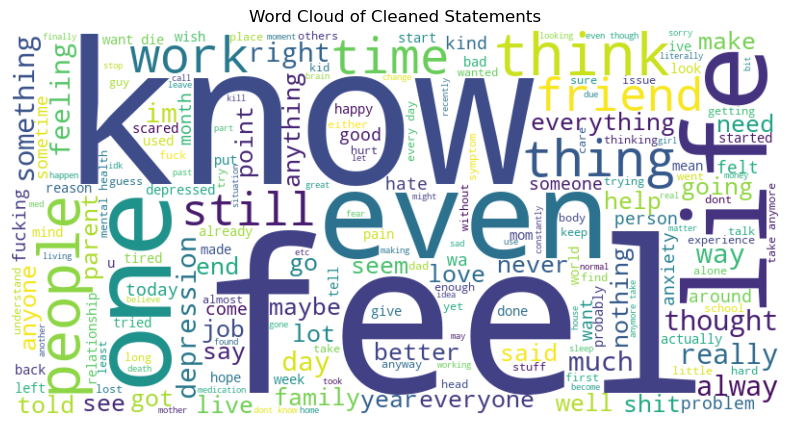

In [23]:

# Word Cloud
all_text = ' '.join(df['cleaned_statement'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Cleaned Statements')
plt.show()

In [24]:
# Status Distribution
fig = px.pie(df, names='status', title='Proportion of Each Status Category')
fig.update_layout(width=800, height=600) 
fig.show()